In [11]:
#importing libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

#importing files
from data_prep import load_data

In [12]:
#load training data
train_df = load_data("FD001","train")
train_df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
train_df.shape

(20631, 26)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   unit_number     20631 non-null  int64  
 1   time_in_cycles  20631 non-null  int64  
 2   op_setting_1    20631 non-null  float64
 3   op_setting_2    20631 non-null  float64
 4   op_setting_3    20631 non-null  float64
 5   sensor_1        20631 non-null  float64
 6   sensor_2        20631 non-null  float64
 7   sensor_3        20631 non-null  float64
 8   sensor_4        20631 non-null  float64
 9   sensor_5        20631 non-null  float64
 10  sensor_6        20631 non-null  float64
 11  sensor_7        20631 non-null  float64
 12  sensor_8        20631 non-null  float64
 13  sensor_9        20631 non-null  float64
 14  sensor_10       20631 non-null  float64
 15  sensor_11       20631 non-null  float64
 16  sensor_12       20631 non-null  float64
 17  sensor_13       20631 non-null 

## Performing Exploratory Data Analysis (EDA)

### 1. Engine Lifetime

Now lets visualize the Engine Lifetimes for each engine (unit_number) and plot the number of cycles it ran before failing. 


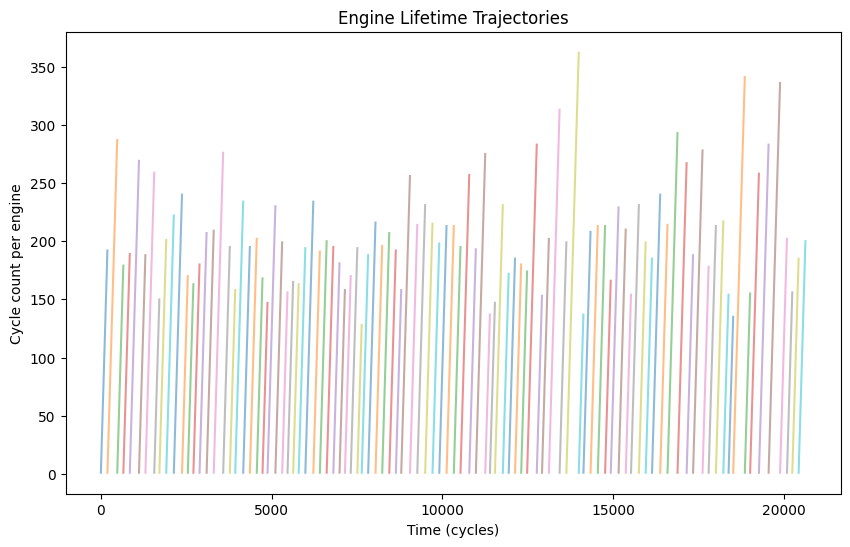

In [15]:
plt.figure(figsize=(10,6))

#Plotting how long each engine ran before it failed
for unit in train_df['unit_number'].unique():
    unit_df = train_df[train_df['unit_number'] == unit]
    plt.plot(unit_df['time_in_cycles'],label=f'Engine {unit}',alpha=0.5) 

plt.xlabel("Time (cycles)")
plt.ylabel("Cycle count per engine")
plt.title("Engine Lifetime Trajectories")

plt.show()

**Inference from the above plot:**

Here each line represents how long an engine lasted in cycles before failing. Engine lifespans vary significantly ranging roughly from 128 to 365 cycles.

This suggests engines operate under different stress levels or usage conditions. Its important to account for this variability when training the RUL prediction model.


### 2. Plotting RUL vs Cycles

**Calculating RUL**

Each Engine runs until failure. for example for each engine:
- The last cycle is when it fails so its RUL is 0
- The second last cycle has RUL = 1 and so on

Therefore we calculate RUL using the following formula: 

RUL = maximum cycle for engine - current cycle 

In [16]:
#adding RUL(Remaining Useful Life) column 
train_df['RUL'] = train_df.groupby('unit_number')['time_in_cycles'].transform("max") - train_df['time_in_cycles']

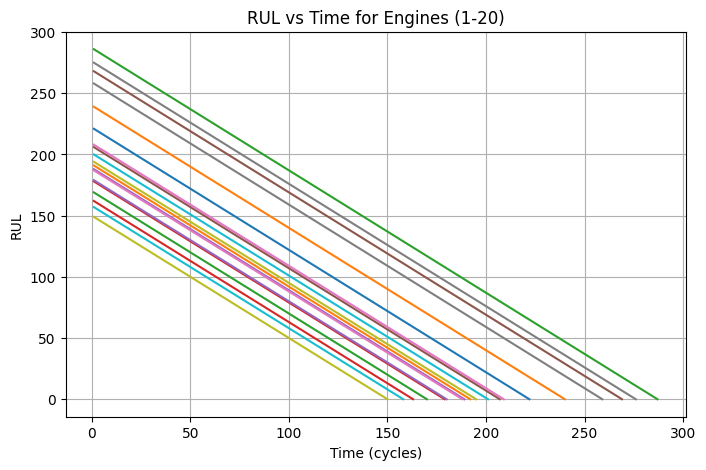

In [17]:
#plot RUL vs Cycle of Engine 56
plt.figure(figsize=(8,5))

for engine in range(20):
    plt.plot(train_df[train_df['unit_number'] == engine]['time_in_cycles'], train_df[train_df['unit_number'] == engine]['RUL'])
plt.xlabel("Time (cycles)")
plt.ylabel("RUL")
plt.title("RUL vs Time for Engines (1-20)")
plt.grid(True)
plt.show()

**Inference from the above graph:**

The Remaining Useful Life (RUL) decreases linearly over time for  almost all the engines in the training set. Since all engines run until failure, the linear decay confirms that the final cycle always has RUL = 0.

### 3. Histograms of Sensor Values

In [18]:
#performing list comprehension to get sensors
sensor_cols = [col for col in train_df.columns if 'sensor_' in col]

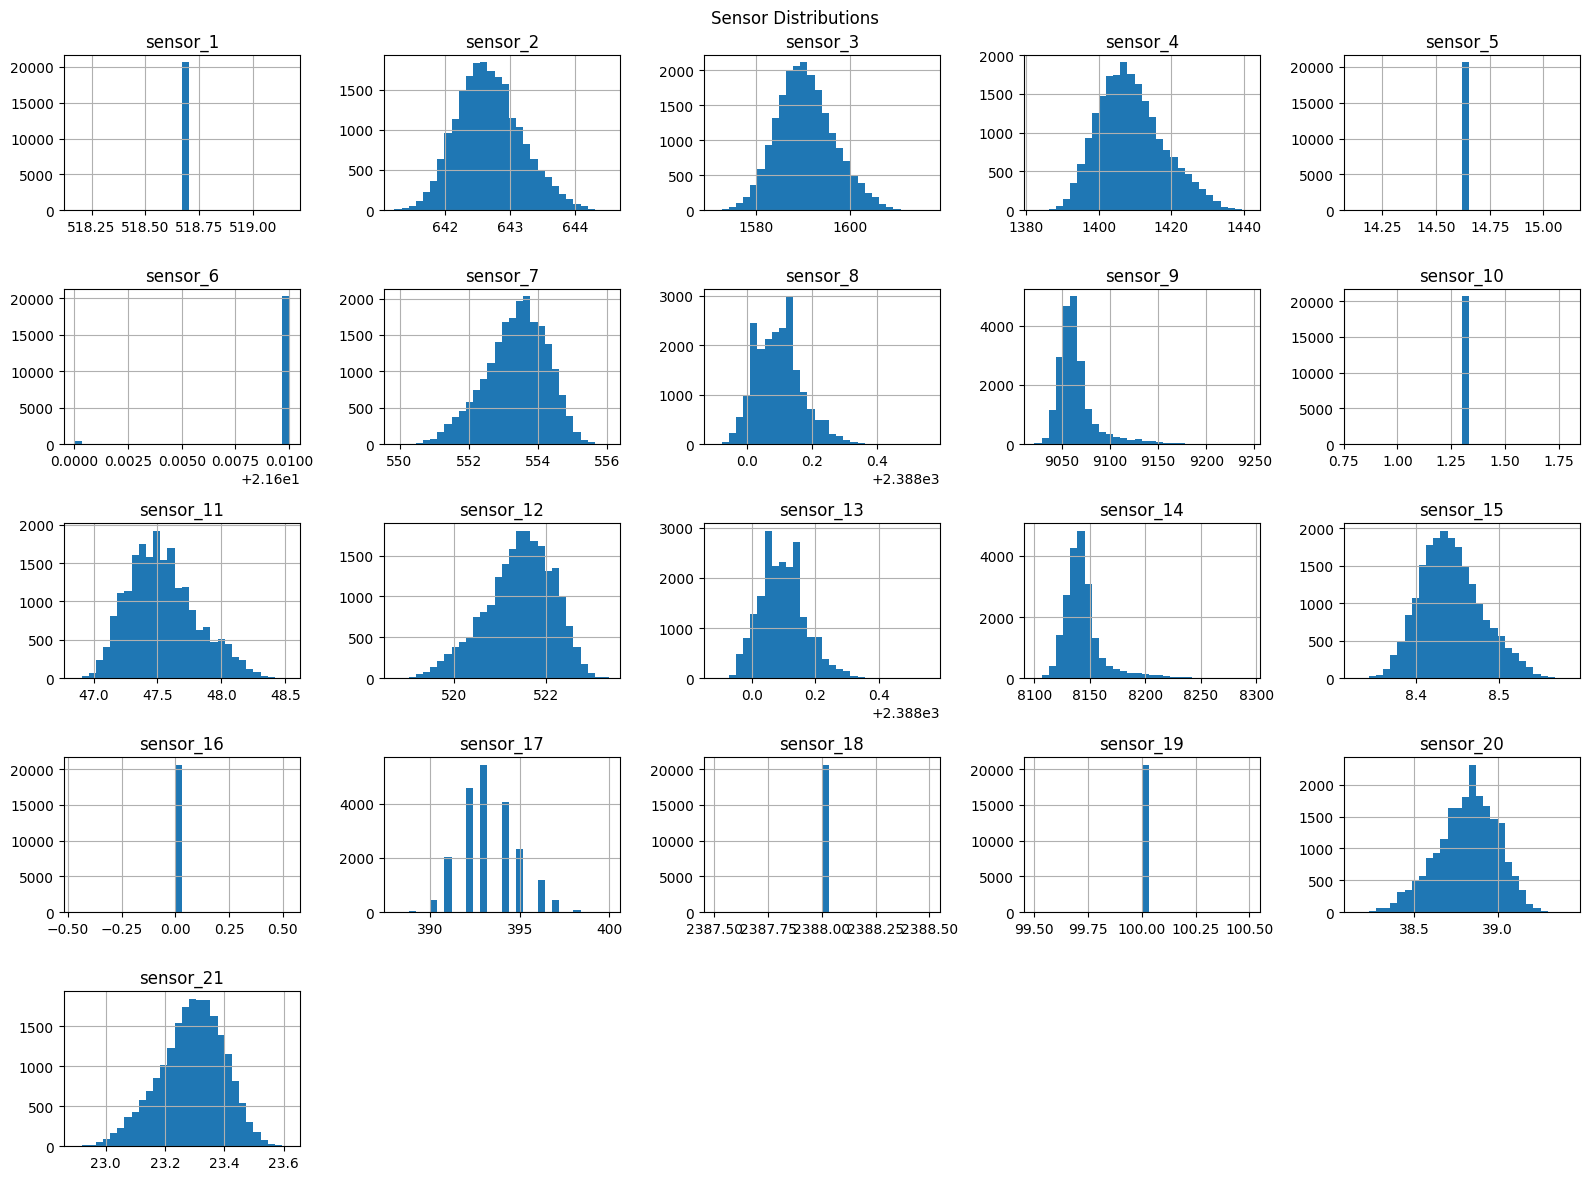

In [19]:
train_df[sensor_cols].hist(figsize=(16,12),bins=30)
plt.suptitle("Sensor Distributions")
plt.tight_layout()
plt.show()

**Inference from the above distributions:**

if we take a look at sensors like sensor_2,sensor_3 etc. these have a wide spread (bell curve or skewed)and they also change across different values, indicating they respond to engine condition this will help the model to learn how engine behavior changes over time. 
and therefore we should keep them.

while sensors like sensor_1,sensor_5 etc have one single value or a very narrow range. i.e they mostly dont change at all. these sensors do not reflect any useful change in the engine health therefore we should drop these from dataset.

and there are few sensors like sensor_8,sensor_9 which may have multimodel or irregular distributions. these sensors might be useful but we need to futher analyse these.


### 4. Correlation Matrix

In [20]:
correlation = train_df[sensor_cols].corr()

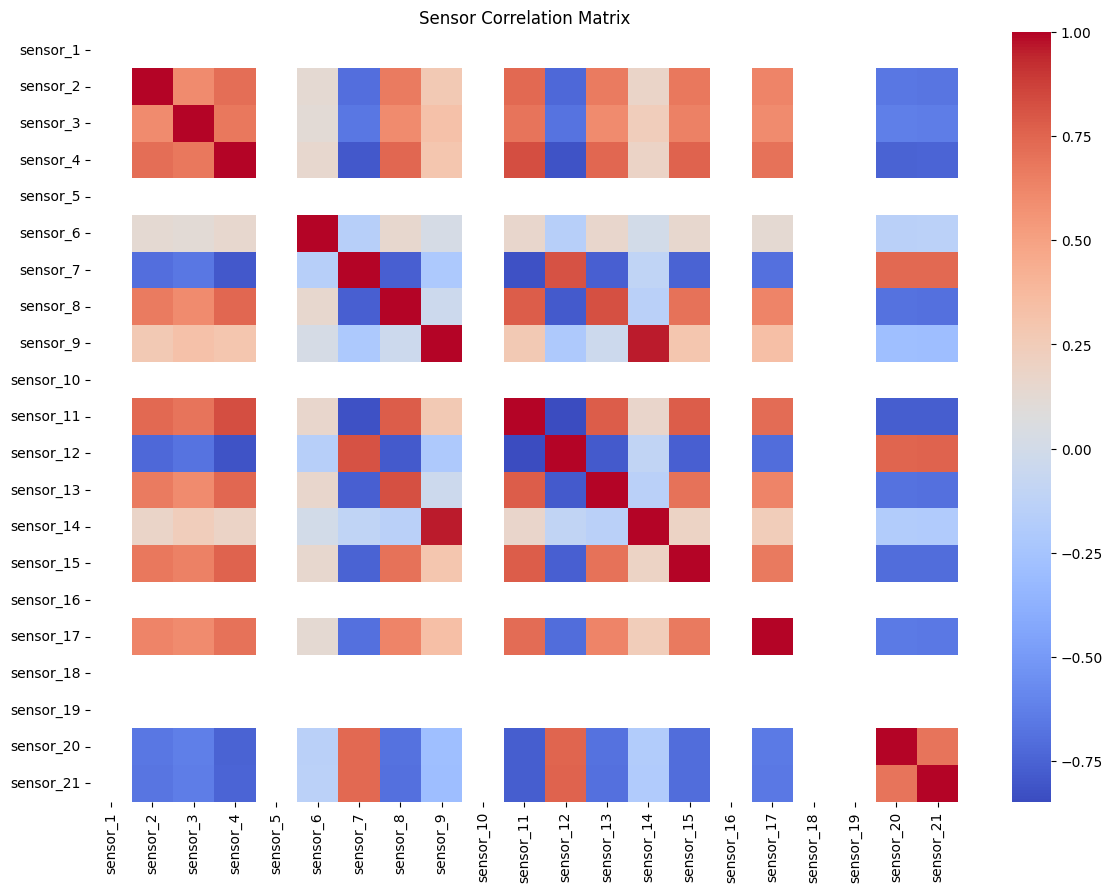

In [21]:
plt.figure(figsize=(14,10))
sns.heatmap(correlation,annot=False,cmap='coolwarm')
plt.title("Sensor Correlation Matrix")
plt.show()

**Inference from the Heatmap:**

the correlation matrix is suggesting potential redundancy. ie.incase of two or more sensors which are highly correlated (ie near 1.0) one of them might be redundant.we can consider dropping one from each highly correlated pair to reduce dimensionality without losing much information.

Some sensors like sensor_10,sensor_18 and sensor_19–21 show weak or very low correlations with others.these might be either noisy, less informative or capturing unique behaviors which are not reflected in other sensors this indicates theirs a need for further investigation regarding their relevance. 


### 5.  Identifying stable and informative sensors

in C-MAPSS dataset we have 21 sensors but not all are useful. now lets calculate the std in order to filter out less informative sensors

Low std: sensor values barely change (maybe useless)

High std: here sensor values vary which might capture machine degradation or changes (useful)

In [22]:
#calculating std for each sensor
sensor_std = train_df[sensor_cols].std()
print(sensor_std)

sensor_1     0.000000e+00
sensor_2     5.000533e-01
sensor_3     6.131150e+00
sensor_4     9.000605e+00
sensor_5     5.329200e-15
sensor_6     1.388985e-03
sensor_7     8.850923e-01
sensor_8     7.098548e-02
sensor_9     2.208288e+01
sensor_10    0.000000e+00
sensor_11    2.670874e-01
sensor_12    7.375534e-01
sensor_13    7.191892e-02
sensor_14    1.907618e+01
sensor_15    3.750504e-02
sensor_16    3.469531e-18
sensor_17    1.548763e+00
sensor_18    0.000000e+00
sensor_19    0.000000e+00
sensor_20    1.807464e-01
sensor_21    1.082509e-01
dtype: float64


In [23]:
stable_sensors = sensor_std[sensor_std > 0.1].index.tolist()
print(stable_sensors)

['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_14', 'sensor_17', 'sensor_20', 'sensor_21']


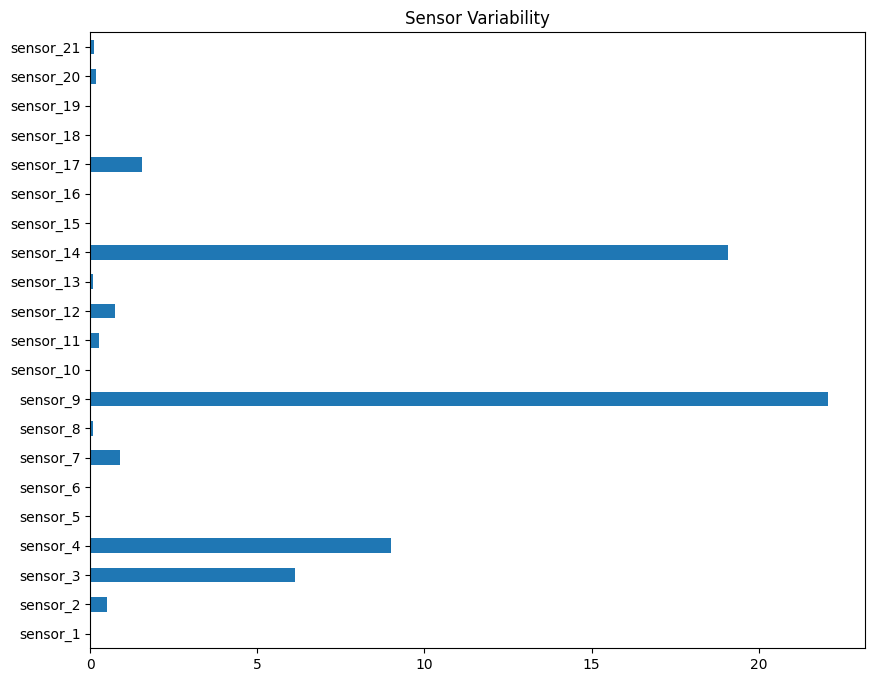

In [24]:
sensor_std.plot(kind='barh', figsize=(10, 8), title='Sensor Variability')
plt.show()


**Inferences from the above bar chart**

sensor_9 and sensor_14 show very high variability compared to other sensors.such sensots are mostly informative. these sensors capture operational changes or degradation patterns leading to failures.

sensor_3 and sensor_4 also have moderate variability. 

The majority of sensors show minimal or close to zero variability. we can consider removing them.They are either not sensitive to operational changes or are constant due to sensor failure, data error or irrelevance to the monitored fault mode.
